<div align="center">
    <h1><b>Reinforcement Learning Assignment</b></h1>
</div>

## Introduction
This notebook is part of an assignment for the course **'Reinforcement Learning & Stochastic Games'** of the **[Department of Informatics and Telecommunications](https://www.di.uoa.gr/)** at the **National and Kapodistrian University of Athens (NKUA)**.

### Purpose
The purpose of this assignment is to **experiment** with various **machine learning algorithms**, in order to train a model on a specific **environment** from **[OpenAI Gym or Gymnasium](https://www.gymlibrary.dev/index.html)**.

### Team Members
The members who contributed to this assignment are as follows:

| First Name | Last Name | Student ID | Email |
| :---: | :---: | :---: | :---: |
| Antonis | Zikas | 1115202100038 | sdi2100038@di.uoa.gr |
| Panagiotis | Papapostolou | 1115202100142 | sdi2100142@di.uoa.gr |

## Environment Selection and Analysis
In this assignment, we chose to work with the **[CartPole-v1](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)** environment, which belongs to the **[Classic Control](https://www.gymlibrary.dev/environments/classic_control/)** category.

<div align="center">
<img src="../assets/imgs/cart-pole-diagram.png" width="500px">    
</div>

Let's analyze this environment.

### Action Space
For this specific environment, there are **two possible actions**. Specifically, the **cart** can move either **left** or **right**. These actions are represented by **0** and **1** respectively and are described in the table below:

| Number | Action |
| :---: | :---: |
| 0 | Move left |
| 1 | Move right |

Therefore, the **action** of this environment is an `ndarray` of shape `(1,)` and can take two values `{0, 1}`.

### Observation Space
The **observation space** for this environment is a collection of **4** values:
1. The **position** of the cart **(Cart Position)**
2. The **velocity** of the cart **(Cart Velocity)**
3. The **angle** formed by the pole with the vertical axis **(Pole Angle)**
4. The **angular velocity** of the pole as it falls **(Pole Angular Velocity)**

These values are stored in an `ndarray` of shape `(4,)` and each value has specific limits, described below:

| Array index | Observation | Min Value | Max Value |
| :---: | :---: | :---: | :---: |
| 0 | Cart Position | $-4.8$ | $4.8$ |
| 1 | Cart Velocity | $-\infty$ | $+\infty$ |
| 2 | Pole Angle | ~ $0.418$ rad (-$24^{\circ}$) | ~ $0.418$ rad ($24^{\circ}$) |
| 3 | Pole Angular Velocity | $-\infty$ | $+\infty$ |

### Reward
For each step during the training of the model, the **reward** received by the selected **agent** is `+1`, including the **termination step**. The **reward threshold** for this environment is **475**.

## Loading the Environment in Python

In [39]:
import gymnasium as gym

env = gym.make('CartPole-v1')
observations = env.observation_space.shape[0]
actions = env.action_space.n

print(f"Observations: {observations}, Actions: {actions}")
env.close()

Observations: 4, Actions: 2


As we observe from the above code execution, the **observations** and **actions** are indeed **4** and **2** respectively. Let’s try running this environment **without** any trained model and observe the results.

In [40]:
epochs = 200
epochs_scores = []
wins = 0
fails = 0

env = gym.make('CartPole-v1')
for epoch in range(1, epochs+1):
    env.reset()
    done = False
    score = 0
    total_steps = 0
    
    while not done:
        action = env.action_space.sample() # Chose a random action from 0 and 1
        observation, reward, terminated, truncated, _ = env.step(action)
        score += reward
        total_steps += 1
        
        if terminated or truncated:
            observation, _ = env.reset()
            done = True

            if terminated and total_steps < epochs:
                fails += 1
            else:
                wins +=1
    
    epochs_scores.append(score)

env.close()

In [41]:
import random
import torch

seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

Let’s visualize the total **score** achieved by our environment for each **epoch**, as well as the number of successes and failures recorded.

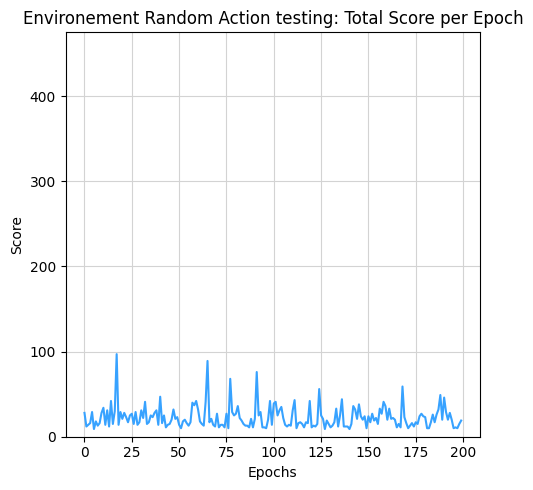

Number of wins: 0
Number of fails: 200


In [42]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 1, figsize=(5, 5))
axis.plot(epochs_scores, color='#37A2FF')
axis.set_ylim(0, 475)
axis.set_title("Environement Random Action testing: Total Score per Epoch")
axis.set_xlabel("Epochs")
axis.set_ylabel("Score")
axis.grid(color='lightgrey')

plt.tight_layout()
plt.show()

print(f'Number of wins: {wins}')
print(f'Number of fails: {fails}')

From the above diagram, we observe that the total **score** achieved by the environment is very low. Our goal, therefore, is to **train** a model so that we manage to increase the **score** up to the corresponding **threshold** of the environment, which is **475**.

## Implementation of the DQN (Deep Q-Network) Algorithm
We will start by implementing the **[DQN](https://medium.com/@samina.amin/deep-q-learning-dqn-71c109586bae)** algorithm, which will be used to train our model. This algorithm requires the use of a **neural network**, for which we will use the **[PyTorch](https://pytorch.org/)** package.

<!-- <div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:2400/format:webp/1*aqNgmfyBIStLrf9k7d9cng.jpeg" width="500px">
</div> -->

### Building the Neural Network
Let’s start with building the **neural network**. The **architecture** of the network will be as follows:
1. **Input Layer** with **4 nodes** (number of observations)
2. **Hidden Layer 1** with **24 nodes**
3. **Hidden Layer 2** with **24 nodes**
4. **Output Layer** with **2 nodes** (number of actions)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, observation):
        x = F.relu(self.fc1(observation))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


### Σύνδεση με συσκευή CPU ή GPU
Θα φροντίσουμε επίσης το νευρωνικό μας δίκτυο να τρέξει σε συσκευή **GPU** (εάν αυτό προφανώς το επιτρέπει το μηχάνημα στο οποίο βρισκόμαστε) για **καλύτερη αποδοτικότητα**. Γι' αυτο το λόγο θα συνδέσουμε το pytorch σε συσκευή **CUDA** εάν είναι διαθέσιμη αλλιώς σε **CPU**.

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Pytorch connected to {device}')

Pytorch connected to cuda


### Κατασκευή Replay Buffer
Στη συνέχεια θα κατασκευάσουμε τη δομή του **ReplayBuffer**, η οποία θα λειτουργεί ως **μνήμη** στην εκπαίδευση του μοντέλου. 

In [45]:
import numpy as np
from collections import deque

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(np.array(states), dtype=torch.float32).to(device),
            torch.tensor(np.array(actions), dtype=torch.long).to(device),
            torch.tensor(np.array(rewards), dtype=torch.float32).to(device),
            torch.tensor(np.array(next_states), dtype=torch.float32).to(device),
            torch.tensor(np.array(dones), dtype=torch.float32).to(device),
        )

    def __len__(self):
        return len(self.buffer)

### Ορισμός Υπερπαραμέτρων (Hyperparameters)
Για την εκπαίδευση του μοντέλου μας χρειαζόμαστε ορισμένες **υπερπαραμέτρους** που θα επηρεάσουν την **εκπαίδευση** του νευρωνικού δικτύου. Μερικές από αυτές τις παραμέτρους είναι το $\gamma$, το $\epsilon$, το **learning rate** κλπ.

In [46]:
# Hyperparameters
GAMMA = 0.99          # Discount factor
LR = 1e-3             # Learning rate
BATCH_SIZE = 64       # Minibatch size
MEMORY_SIZE = 10000   # Replay buffer size
EPSILON_START = 1.0   # Starting exploration probability
EPSILON_END = 0.01    # Minimum exploration probability
EPSILON_DECAY = 0.995 # Epsilon decay rate
TARGET_UPDATE = 10    # How often to update the target network

### Δημιουργία Νευρωνικών Δικτύων
Στη συνέχεια θα ορίσουμε δύο νευρωνικά δίκτυα όπου το ένα θα παίζει το ρόλο της **πολιτικής** που θα χρησιμοποιήσουμε στη διαδικασία εκπαίδευσης, και το άλλο θα παίζει το ρόλο του **στόχου**.

In [47]:
# Initialize networks, optimizer, and replay buffer
policy_net = DQN(observations, actions).to(device)
target_net = DQN(observations, actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

policy_net.eval()

DQN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

### Δημιουργία του Optimizer και του Replay Buffer
Θα δημιουργήσουμε επίσης τον **optimizer** που θα χρησιμοποιήσουμε στην εκπαίδευση του μοντέλου και το **replay buffer** που θα παίζει το ρόλο της μνήμης. Για τον optimizer θα χρησιμοποιήσουμε τον **Adam**.

In [48]:
import torch.optim as optim

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
replay_buffer = ReplayBuffer(MEMORY_SIZE)

### Ορισμός πολιτικής E-Greedy
Θα πρέπει επίσης να ορίσουμε την $\epsilon$ greedy πολιτική του αλγορίθμου μας που θα χρησιμοποιεί τις **υπερπαραμέτρους** που ορίσαμε παραπάνω για το $\epsilon$. Με αυτόν τον τρόπο κάθε φορά θα επιλέγεται μία **ενέργεια** του περιβάλλοντος είτε **τυχαία** είτε μέσω του **νευρωνικού** που ορίσαμε.

In [49]:
# Epsilon-greedy policy
def select_action(state):
    global epsilon
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            return policy_net(state).argmax(dim=1).item()  # Exploit

### Διαδικασία Εκπαίδευσης
Ήρθε λοιπόν η ώρα να ορίσουμε τη διαδικασία εκπαίδευσης του μοντέλου μας.

In [50]:
import random
import torch
import torch.nn as nn

total_rewards = []
max_reward = -1
epsilon = EPSILON_START

def train_model(env, epochs):
    global epsilon, max_reward, max_reward

    for episode in range(epochs):
        total_reward = run_episode(env, episode)

        # Track and save the best model
        total_rewards.append(total_reward)
        if total_reward > max_reward:
            max_reward = total_reward
            torch.save(policy_net.state_dict(), "best_network.pth")


def run_episode(env, episode):
    global epsilon
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        total_reward += reward
        state = next_state

        if len(replay_buffer) > BATCH_SIZE:
            train_step()

    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    return total_reward

def train_step():
    states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)
    states, actions, rewards, next_states, dones = (
        states.to(device), actions.to(device), rewards.to(device),
        next_states.to(device), dones.to(device)
    )

    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        next_q_values = target_net(next_states).max(dim=1)[0]
        target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


### Εκπαίδευση Μοντέλου
Ας δοκιμάσουμε τη μέθοδό μας εκπαιδεύοντας ένα μοντέλο για το συγκεκριμένο περιβάλλον.

In [51]:
env = gym.make('CartPole-v1')
train_model(env, 200)
env.close()

Ας δούμε τα αποτελέσματα της εκπαίδευσης.

<Figure size 640x480 with 0 Axes>

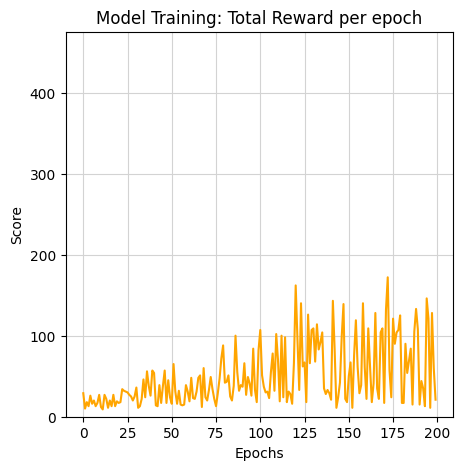

In [52]:
from matplotlib import pyplot as plt

plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(total_rewards, color='orange')
plt.ylim(0, max(475, max(total_rewards)))
plt.title("Model Training: Total Reward per epoch")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.grid(color='lightgrey')
plt.show()

In [53]:
print(max(total_rewards))

172.0


In [54]:
import torch
import gymnasium as gym

def test_agent(env, policy_net, num_episodes=10):
    wins, fails = 0, 0
    epochs_scores = []

    for episode in range(num_episodes):
        total_reward, total_steps, terminated = run_test_episode(env, policy_net)

        if terminated and total_steps < num_episodes:
            fails += 1
        else:
            wins += 1

        epochs_scores.append(total_reward)

    env.close()
    return wins, fails, epochs_scores


def run_test_episode(env, policy_net):
    state, _ = env.reset()
    total_reward = 0
    done = False
    total_steps = 0

    while not done:
        action = select_action(policy_net, state)
        state, reward, terminated, done = step_test_environment(env, action, state)
        total_reward += reward
        total_steps += 1

    return total_reward, total_steps, terminated


def select_action(policy_net, state):
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        action = policy_net(state_tensor).argmax(dim=1).item()
    return action


def step_test_environment(env, action, state):
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    return next_state, reward, terminated, done


In [55]:
env = gym.make('CartPole-v1')

observations = env.observation_space.shape[0]
actions = env.action_space.n

# Call the test function
policy_net = DQN(observations, actions).to(device)
policy_net.load_state_dict(torch.load('./best_network.pth'))
policy_net.eval()

wins, fails, epochs_rewards = test_agent(env, policy_net, num_episodes=200)

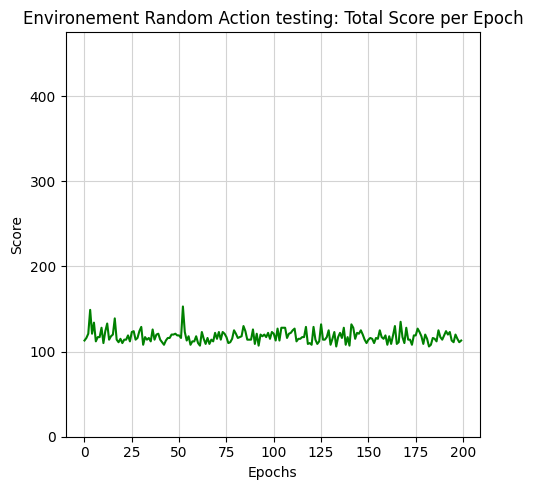

In [56]:
figure, axis = plt.subplots(1, 1, figsize=(5, 5))
axis.plot(epochs_rewards, color='green')
axis.set_ylim(0, max(475, max(epochs_rewards)+10))
axis.set_title("Environement Random Action testing: Total Score per Epoch")
axis.set_xlabel("Epochs")
axis.set_ylabel("Score")
axis.grid(color='lightgrey')

plt.tight_layout()
plt.show()

In [57]:
fails, wins

(200, 0)